<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Assignment_3_Evolutionary_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
pip install ucimlrepo

In [ ]:
pip install scikit-fuzzy

In [ ]:
pip install deap

In [ ]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
# from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import statistics
import random
import itertools
from itertools import product
from functools import reduce

from sklearn.exceptions import ConvergenceWarning
import warnings
import sys

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# data (as pandas dataframes)
X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

# Dataset Cleaning and Preprocessing

In [ ]:
features = X.copy()

# Check for null values
print("Columns with null value")
print("-----------------------------------")
print("{:15} {:15}".format("Column","Num of null values"))
for col in features.columns:
  number_of_null_values = features[col].isna().sum()
  if number_of_null_values > 0:
    print(col)
    print("{:-15} {:-15}".format(col,number_of_null_values))

Columns with null value
-----------------------------------
Column          Num of null values


In [ ]:
# Check for col with object dtype
features.select_dtypes('object').columns

Index([], dtype='object')

In [ ]:
features.select_dtypes('int').columns

Index([' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [ ]:
print("Unique value of Liability-Assets Flag : ", features[' Liability-Assets Flag'].unique())
print("Unique value of Net Income Flag : ", features[' Net Income Flag'].unique())

Unique value of Liability-Assets Flag :  [0 1]
Unique value of Net Income Flag :  [1]


In [ ]:
print("Number of Liability-Assets Flag == 0 : ",len(features[features[' Liability-Assets Flag'] == 0]))
print("Number of Liability-Assets Flag == 1 : ",len(features[features[' Liability-Assets Flag'] == 1]))

Number of Liability-Assets Flag == 0 :  6811
Number of Liability-Assets Flag == 1 :  8


In [ ]:
features.drop(columns = features.select_dtypes('int').columns,inplace = True)

In [ ]:
# Imbalance Dataset
print("Number of Bankrupt == 0 : " , len(y[y['Bankrupt?'] == 0]))
print("Number of Bankrupt == 1 : " , len(y[y['Bankrupt?'] == 1]))

Number of Bankrupt == 0 :  6599
Number of Bankrupt == 1 :  220


In [ ]:
df = pd.concat([features,y],axis = 1)
df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490,1


In [ ]:
# all_features = df.drop(columns=['Bankrupt?'])
# bankrupt = df['Bankrupt?']
# smote = SMOTE(random_state=42)
# all_features_resampled, bankrupt_resampled = smote.fit_resample(all_features, bankrupt)

In [ ]:
# df = all_features_resampled.join(bankrupt_resampled)
# print("Duplicated rows after upsampling?:", df.duplicated().sum())
# print("Number of rows of features dataframe : ", len(df))
# print("Number of Bankrupt == 0 : " , len(df[df['Bankrupt?'] == 0]))
# print("Number of Bankrupt == 1 : " , len(df [df['Bankrupt?'] == 1]))

# df.head()

In [ ]:
# Downsampling
features_majority = df[df['Bankrupt?'] == 0]
features_minority = df[df['Bankrupt?'] == 1]

features_majority_downsample = resample(
    features_majority,
    replace = False,
    n_samples = len(features_minority),
    random_state = 123
)

df = pd.concat([features_minority,features_majority_downsample])

print("Number of rows of features dataframe : ", len(df))
print("Number of Bankrupt == 0 : " , len(df[df['Bankrupt?'] == 0]))
print("Number of Bankrupt == 1 : " , len(df [df['Bankrupt?'] == 1]))

df.head()

Number of rows of features dataframe :  440
Number of Bankrupt == 0 :  220
Number of Bankrupt == 1 :  220


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490,1


In [ ]:
# Split Dataset into train and test sets
X = df.drop(['Bankrupt?'],axis = 1)
y = df['Bankrupt?']
X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 42
)

print("Training features : ", len(X_train))
print("Testing features  : ", len(X_test))
print("Training labels   : ", len(y_train))
print("Testing labels    : ", len(y_test))

Training features :  396
Testing features  :  44
Training labels   :  396
Testing labels    :  44


# Features Selection - GA algorithms <br>
**Types of fitness function : Fitness range (-1 <= x <= 1)**

    1. Logistics Regression
    2. Random Forest Regression

    ### Penalty
    -Deduction of 0.1 is applied for each feature that exceeds the specified range(10).

**Selection methods**

    1. Tournament Selection
    2. Rank Selection
    3. Roulette-wheel Selection

**Mutation methods**

    1. Bit Flip Mutation
    2. Gaussian Mutation

**Stopping Criteria**

    1. When fitness value > 0.998
    2. When best fitness value does not improve for 40 consecutive generations

**Changes of mutation and crossover rate every generation loop [TRUE / FALSE]**

    1. crossover_rate *= 1.05
    2. mutation_rate *= 0.99














In [ ]:
# Deduct fitness score when the number of features > 10
# Penalty of 0.1 is applied for each feature that exceeds the specified range.
def penalty_function(selected_features,score):
    num_features = len(selected_features)
    if num_features > 10:
      score -= (num_features - 10) /10
    return score

def fitness_function_random_forest(individual,data,target):
  # Filter the features based on the individual's chromosome
  selected_features = [feature for feature,bit in zip(data.columns,individual) if bit == 1]
  if not selected_features:
    return (0.0,)
  X = data[selected_features]
  model = RandomForestClassifier(random_state = 42)
  model.fit(X,target)
  score =model.score(X_test[selected_features],y_test)

  score = penalty_function(selected_features,score)

  return (score,)

def fitness_function_logistics_regression(individual,data,target):
  selected_features = [feature for feature,bit in zip(data.columns,individual) if bit == 1]
  if not selected_features:
    return (0.0,)
  X = data[selected_features]
  model = LogisticRegression()
  model.fit(X,target)
  pred = model.predict(X_test[selected_features])
  acc = accuracy_score(y_test,pred)

  acc = penalty_function(selected_features,acc)

  return (acc,)

In [ ]:
# Define a random state seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

def feature_selection_genetic_algo(data,features,target,population_size,num_generations,fitness_type,num_desired_features = 10,selection_type = 'tournament',mutation_type = 'bitflip',crossover_rate = 0.7,mutation_rate = 0.01,changes_of_rates = True):
  collection_of_fitnesses = []
  best_fitness_in_generation = -sys.float_info.max
  best_ind_in_generation = None

  # Create the Fitness and Individual classes
  creator.create("FitnessMax",base.Fitness,weights = (1.0,))
  creator.create("Individual",list,fitness = creator.FitnessMax)

  # Initialize the toolbox
  toolbox = base.Toolbox()

  # Attribute generator: Define a function to randomly generate a feature selector (0 or 1)
  toolbox.register('attr_bool',random.randint,0,1)

  # Structure initializers: Define a function to create individuals and the population
  # toolbox.register('individual',init_individual,creator.Individual,size = len(features),num_features = 10)
  toolbox.register('individual',tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(features))
  toolbox.register('population',tools.initRepeat,list,toolbox.individual)

  # Register the evaluation function
  if fitness_type == 'randomforest':
    toolbox.register("evaluate",fitness_function_random_forest,data = data,target = target)
  elif fitness_type == 'logistic':
    toolbox.register("evaluate",fitness_function_logistics_regression,data = data,target = target)

  toolbox.register('mate',tools.cxTwoPoint)

  if mutation_type == 'bitflip':
    toolbox.register('mutate',tools.mutFlipBit,indpb = 0.05)
  elif mutation_type == 'gaussian':
    toolbox.register('mutate',tools.mutGaussian,mu = 0,sigma = 1,indpb = 0.5)

  if selection_type == 'tournament':
    toolbox.register('select',tools.selTournament,tournsize  = 3)
  elif selection_type == 'roulette':
    toolbox.register('select',tools.selRoulette)
  elif selection_type == 'rank':
    toolbox.register('select',tools.selBest)

  # Initialize population
  population = toolbox.population(n = population_size)

  fitnesses = list(map(toolbox.evaluate,population))

  for ind,fit in zip(population,fitnesses):
    ind.fitness.values = fit

  # Variable keeping track of the number of generations
  gen = 0

  count_num_gen = 0

  while gen < num_generations:

    gen+=1

    # Select the next generation individuals
    offspring = toolbox.select(population,len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone,offspring))

    # Apply crossover and mutation on the offspring
    for child1,child2 in zip(offspring[::2],offspring[1::2]):
      if random.random() < crossover_rate:
        toolbox.mate(child1,child2)
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
      if random.random() < mutation_rate:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

    fitnesses = map(toolbox.evaluate,invalid_ind)

    for ind,fit in zip(invalid_ind,fitnesses):
      ind.fitness.values = fit

    # Replace the population with the offspring
    population[:] = offspring

    # Stopping criteria
    try:
      best_ind_in_population = tools.selBest(population,1)[0]
      best_fitness_in_population = best_ind_in_population.fitness.values[0]
    except IndexError:
      break

    selected_features = [feature for feature,bit in zip(data.columns,best_ind_in_population) if bit == 1]

    # print("Generation        : ",gen)
    # print("Selected Features : ",selected_features)
    # print("Best Fitness      : ",best_fitness_in_population)
    # print()

    if changes_of_rates:
        #  Modify crossover rate and mutation -rate every generation loop
        crossover_rate *= 1.05
        mutation_rate *= 0.99

    collection_of_fitnesses.append(best_fitness_in_population)

    if best_fitness_in_population > best_fitness_in_generation:
      best_fitness_in_generation = best_fitness_in_population
      best_ind_in_generation = best_ind_in_population
      count_num_gen = 0
    else:
      count_num_gen += 1

    if best_fitness_in_population >= 0.998:
      print("\n Met Stopping Criteria - best_fitness_in_population >= 0.998")
      break

    if count_num_gen == 40:
      print("\nMet Stopping Criteria - count_num_gen == 40")
      break

  # Select the top N features from the best individual
  selected_features = [features[i] for i in range(len(best_ind_in_generation)) if best_ind_in_generation[i] == 1]

  if len(selected_features) > num_desired_features:
    X = data[selected_features]
    model = RandomForestClassifier()
    model.fit(X,target)
    feature_importances = model.feature_importances_
    important_features = sorted(zip(selected_features,feature_importances),key = lambda x : x[1],reverse = True)
    best_features = [feature for feature,importance in important_features[:num_desired_features]]
  else:
    best_features = selected_features

  return collection_of_fitnesses,best_features,best_fitness_in_generation

In [ ]:
# Plot the convergence
def plot_fitness_history(fitnesses,title):
  plt.plot(fitnesses)
  plt.xlabel("Generation")
  plt.ylabel("Best Fitness Value")
  plt.title(title)
  plt.grid()
  plt.show()

In [ ]:
def run_feature_selection_ga(setting,title,data,feature,target,population_size,num_generations,
                             fitness_type,num_desired_features,selection_type,mutation_type,
                             crossover_rate,mutation_rate,changes_of_rates):

  fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

  all_best_fitness.append(best_fitness)
  all_best_features.append(best_features)
  print("\nSetting        : ", setting)
  print("Best Features  : ", best_features)
  print("Best Fitness   : ", best_fitness)
  plot_fitness_history(fitnesses, title)

In [ ]:
# Parameters
data = X_train
features = X_train.columns
target = y_train
num_desired_features = 10
population_size = 30
num_generations = 80

all_best_fitness = []
all_best_features = []

### **Fitness Function with Logistic Regression**

**Fixed MUT,SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'tournament', 'bitflip', 0.7, 0.1, False]
Best Features  :  [' Operating Profit Rate', ' Net Value Per Share (A)', ' Operating Profit Per Share (Yuan ¥)', ' After-tax Net Profit Growth Rate', ' Interest Expense Ratio', ' Net worth/Assets', ' Average Collection Days', ' Net Worth Turnover Rate (times)', ' Current Liabilities/Liability', ' Cash Flow to Liability']
Best Fitness   :  0.8409090909090909


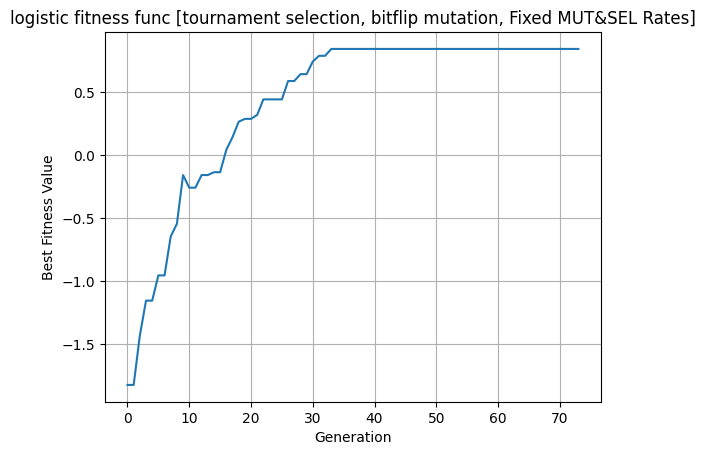

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'rank', 'bitflip', 0.7, 0.1, False]
Best Features  :  [' Retained Earnings to Total Assets', ' Debt ratio %', ' Continuous interest rate (after tax)', ' Net worth/Assets', ' ROA(B) before interest and depreciation after tax', " Net Income to Stockholder's Equity", ' Interest Expense Ratio', ' Net Value Per Share (A)', ' Current Liability to Equity', ' Cash/Total Assets']
Best Fitness   :  -0.359090909090909


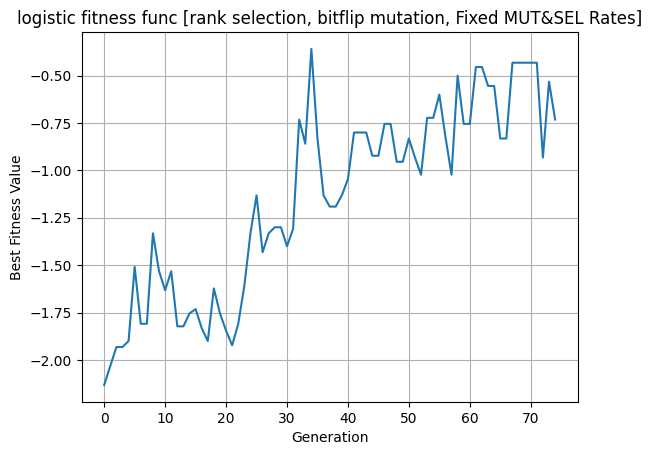

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Setting        :  ['logistic', 'roulette', 'bitflip', 0.7, 0.1, False]
Best Features  :  [' Persistent EPS in the Last Four Seasons', ' Continuous interest rate (after tax)', ' Pre-tax net Interest Rate', ' Total income/Total expense', ' Non-industry income and expenditure/revenue', ' ROA(B) before interest and depreciation after tax', ' Net Value Per Share (A)', ' Current Liability to Assets', ' Cash flow rate', ' ROA(A) before interest and % after tax']
Best Fitness   :  -0.9772727272727273


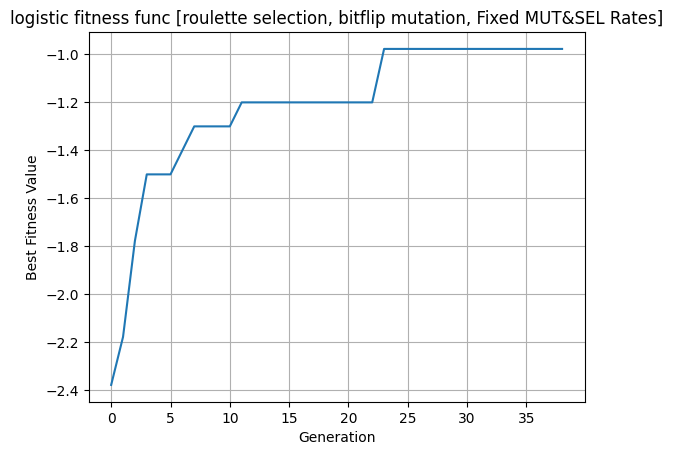

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'tournament', 'gaussian', 0.7, 0.1, False]
Best Features  :  [' Net worth/Assets', ' Long-term fund suitability ratio (A)', ' Borrowing dependency', ' Contingent liabilities/Net worth', ' Operating profit/Paid-in capital', ' Working Capital/Equity', ' Cash Flow to Sales', ' Cash Flow to Total Assets', ' Net Income to Total Assets', ' Liability to Equity']
Best Fitness   :  0.9090909090909091


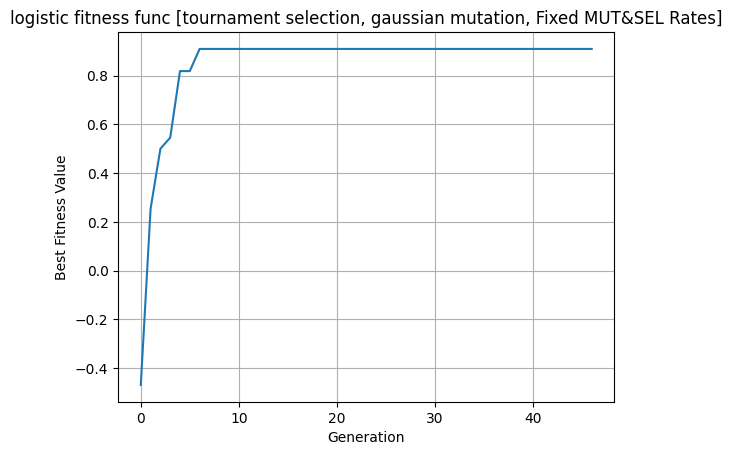

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'rank', 'gaussian', 0.7, 0.1, False]
Best Features  :  [' Persistent EPS in the Last Four Seasons', ' Per Share Net profit before tax (Yuan ¥)', ' After-tax Net Profit Growth Rate', ' Net Worth Turnover Rate (times)', ' Current Liability to Assets', ' Current Liabilities/Liability', ' Total expense/Assets', ' Cash Flow to Sales', ' CFO to Assets']
Best Fitness   :  0.9318181818181818


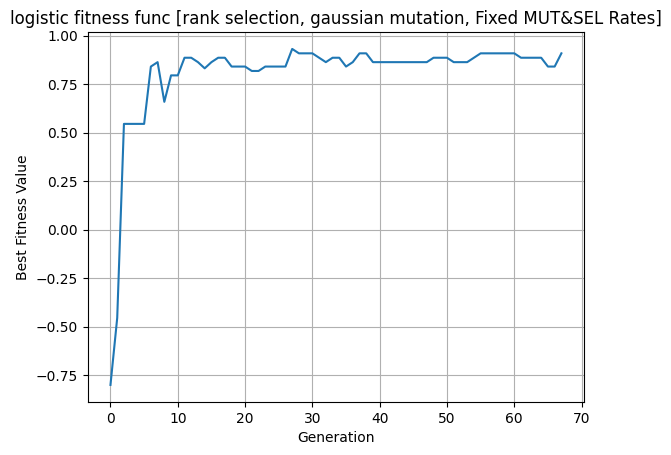

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'roulette', 'gaussian', 0.7, 0.1, False]
Best Features  :  [' ROA(B) before interest and depreciation after tax', ' Working Capital to Total Assets', ' Total expense/Assets', ' Cash Flow to Sales', ' Current Liability to Current Assets']
Best Fitness   :  0.8181818181818182


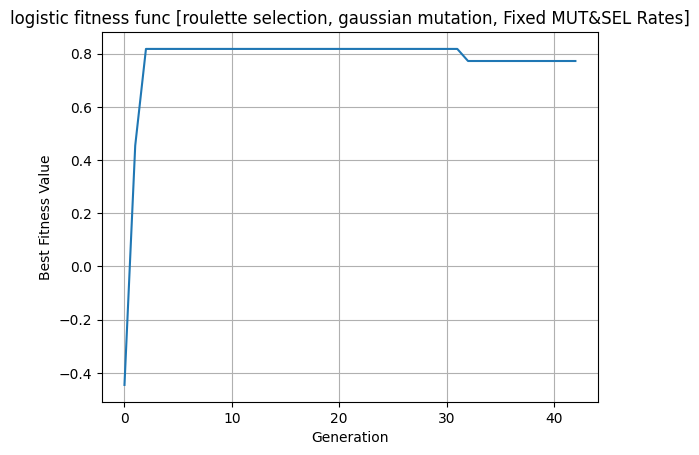

In [ ]:
settingsLog1 = [
    # Dataset,features,target,population_size,number of generation, fitness type, number of desired features, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'tournament','bitflip',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'rank','bitflip',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'roulette','bitflip',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'tournament','gaussian',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'rank','gaussian',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'roulette','gaussian',0.7,0.1,False],
]

for setting in settingsLog1:
    fitness_type = setting[5]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_feature_selection_ga(setting,title,data,features,target,population_size,num_generations,fitness_type,num_desired_features,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()

**Dynamic MUT&SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Setting        :  ['logistic', 'tournament', 'bitflip', 0.7, 0.1, True]
Best Features  :  [' Net Income to Total Assets', ' Net worth/Assets', ' Interest Expense Ratio', ' Net Value Per Share (B)', ' Interest Coverage Ratio (Interest expense to EBIT)', ' Net Value Per Share (C)', ' Current Ratio', ' Operating Profit Rate', ' Tax rate (A)', ' Allocation rate per person']
Best Fitness   :  0.26363636363636367


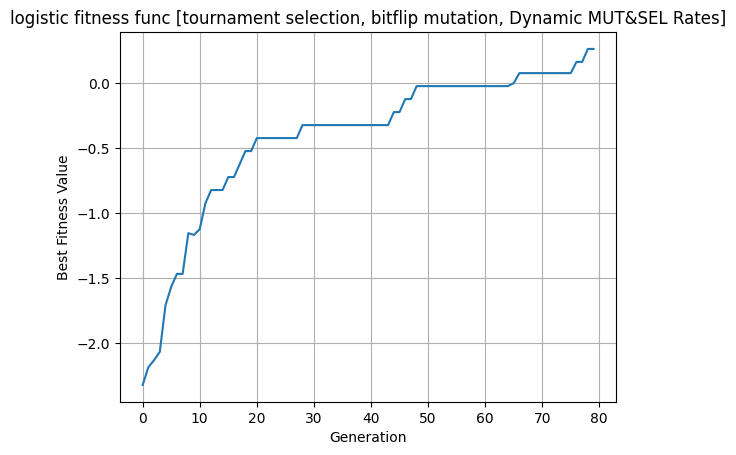

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'tournament', 'gaussian', 0.7, 0.1, True]
Best Features  :  [' ROA(C) before interest and depreciation before interest', ' Operating Gross Margin', ' Net Value Per Share (C)', ' Cash Flow Per Share', ' Quick Assets/Total Assets', ' Fixed Assets to Assets', ' Cash Flow to Total Assets', ' Cash Flow to Equity']
Best Fitness   :  0.8181818181818182


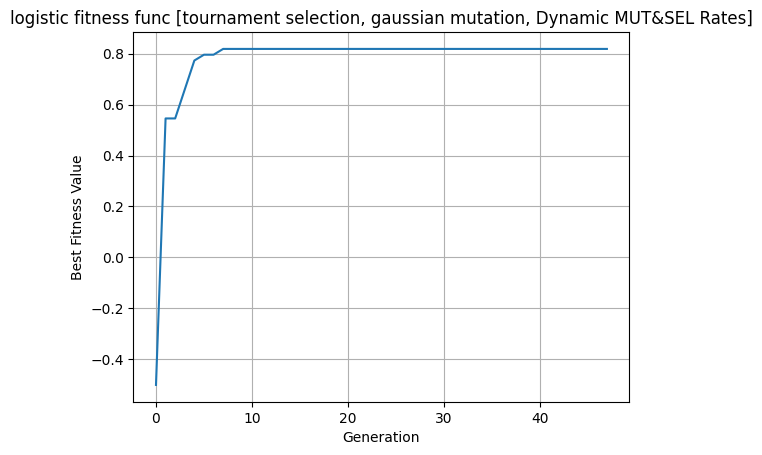

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'rank', 'gaussian', 0.7, 0.1, True]
Best Features  :  [' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' Operating profit per person', ' Current Liabilities/Liability', ' Total income/Total expense', ' Cash Flow to Sales', ' Equity to Liability']
Best Fitness   :  0.9090909090909091


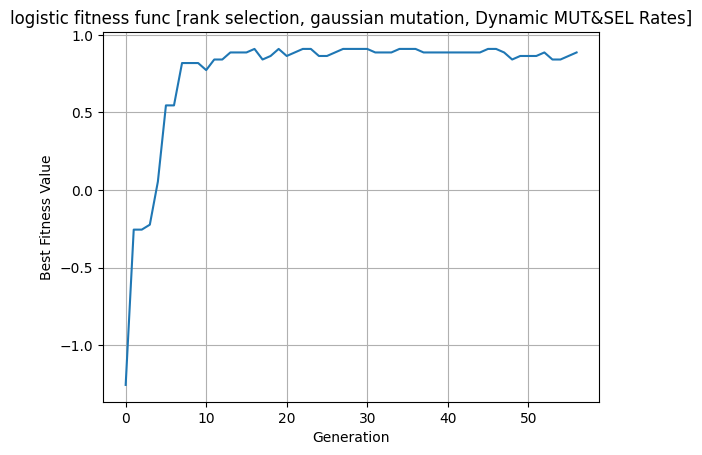

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['logistic', 'roulette', 'gaussian', 0.7, 0.1, True]
Best Features  :  [' Net Value Per Share (A)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Total debt/Total net worth', ' Inventory and accounts receivable/Net value', ' Total Asset Turnover', ' Cash/Total Assets', ' Fixed Assets to Assets', ' Current Liability to Equity']
Best Fitness   :  0.8409090909090909


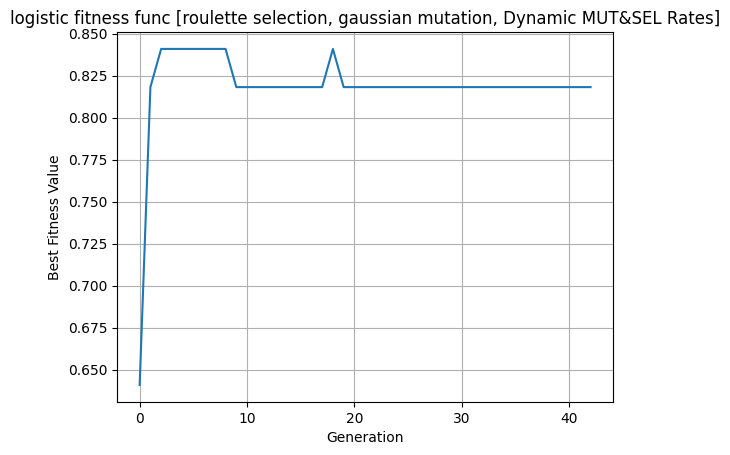

In [ ]:
settingsLog2 = [
    # Dataset,features,target,population_size,number of generation, fitness type, number of desired features, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'tournament','bitflip',0.7,0.1,True],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'tournament','gaussian',0.7,0.1,True],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'rank','gaussian',0.7,0.1,True],
    [data,features,target,population_size,num_generations,'logistic',num_desired_features,'roulette','gaussian',0.7,0.1,True],
]

for setting in settingsLog2:
    fitness_type = setting[5]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_feature_selection_ga(setting,title,data,features,target,population_size,num_generations,fitness_type,num_desired_features,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()

In [ ]:
best_fitness_value_index_logisticRegression = np.argmax(all_best_fitness)

logistic_best_features = all_best_features[best_fitness_value_index_logisticRegression]
logistic_best_fitness = all_best_fitness[best_fitness_value_index_logisticRegression]

all_settings = settingsLog1 + settingsLog2
print(best_fitness_value_index_logisticRegression)
best_setting = [all_settings[best_fitness_value_index_logisticRegression][5],
      all_settings[best_fitness_value_index_logisticRegression][7],
      all_settings[best_fitness_value_index_logisticRegression][8],
      all_settings[best_fitness_value_index_logisticRegression][9],
      all_settings[best_fitness_value_index_logisticRegression][10],
      all_settings[best_fitness_value_index_logisticRegression][11]]

print("Logistic Regression ")
print("Best Settings      - ", best_setting)
print("Best Fitness Value - ", logistic_best_fitness)
print("Best Features      - ", logistic_best_features)

Logistic Regression 
Best Settings      -  ['logistic', 'rank', 'gaussian', 0.7, 0.1, False]
Best Fitness Value -  0.9318181818181818
Best Features      -  [' Persistent EPS in the Last Four Seasons', ' Per Share Net profit before tax (Yuan ¥)', ' After-tax Net Profit Growth Rate', ' Net Worth Turnover Rate (times)', ' Current Liability to Assets', ' Current Liabilities/Liability', ' Total expense/Assets', ' Cash Flow to Sales', ' CFO to Assets']


### **Fitness Function with Random Forest Classifier**

In [ ]:
all_best_features = []
all_best_fitness = []

**Fixed MUT&SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Setting        :  ['randomforest', 'tournament', 'bitflip', 0.7, 0.1, False]
Best Features  :  [' Continuous interest rate (after tax)', ' Net worth/Assets', ' Net Income to Total Assets', ' Per Share Net profit before tax (Yuan ¥)', ' Current Liability to Equity', ' After-tax net Interest Rate', ' Working capitcal Turnover Rate', ' Regular Net Profit Growth Rate', ' No-credit Interval', ' Realized Sales Gross Profit Growth Rate']
Best Fitness   :  0.6863636363636363


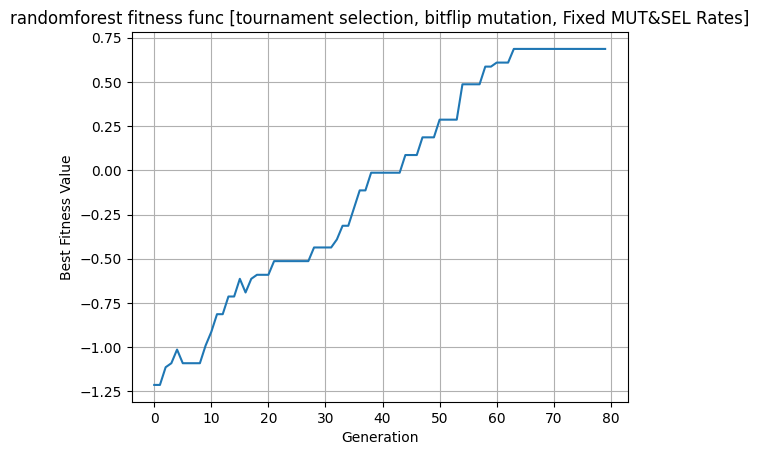

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Setting        :  ['randomforest', 'rank', 'bitflip', 0.7, 0.1, False]
Best Features  :  [' Borrowing dependency', ' Current Liability to Equity', ' Operating profit/Paid-in capital', ' Operating Profit Rate', ' Tax rate (A)', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Total Asset Return Growth Rate Ratio', ' Realized Sales Gross Margin', ' Cash/Current Liability']
Best Fitness   :  0.2090909090909091


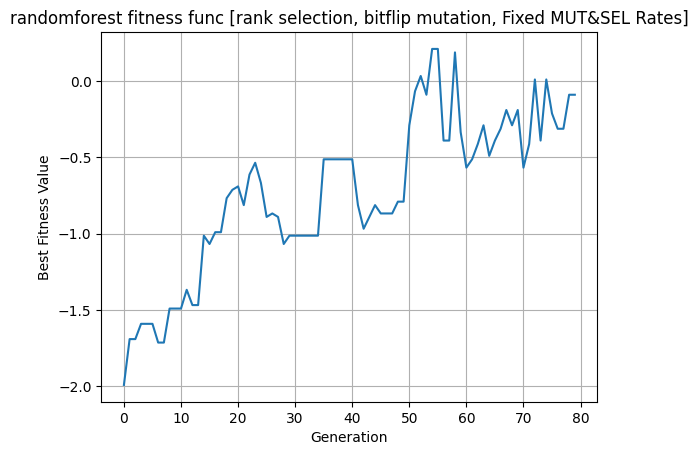

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Setting        :  ['randomforest', 'roulette', 'bitflip', 0.7, 0.1, False]
Best Features  :  [' Borrowing dependency', ' Net Income to Total Assets', ' Retained Earnings to Total Assets', ' Debt ratio %', ' Net profit before tax/Paid-in capital', ' Non-industry income and expenditure/revenue', ' Net Value Per Share (A)', ' ROA(A) before interest and % after tax', ' Total income/Total expense', ' Current Liability to Current Assets']
Best Fitness   :  -0.7681818181818182


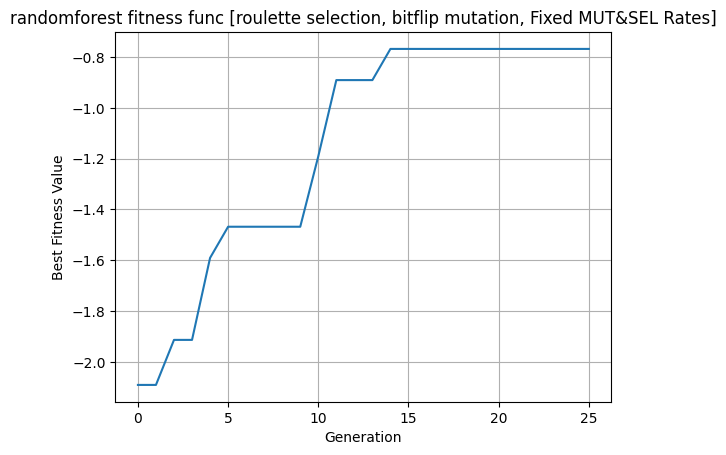

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['randomforest', 'tournament', 'gaussian', 0.7, 0.1, False]
Best Features  :  [' Total Asset Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Net profit before tax/Paid-in capital', ' Working Capital to Total Assets', ' Inventory/Current Liability', ' Long-term Liability to Current Assets', ' Total income/Total expense', ' Current Liability to Equity', " Net Income to Stockholder's Equity", ' Liability to Equity']
Best Fitness   :  0.9090909090909091


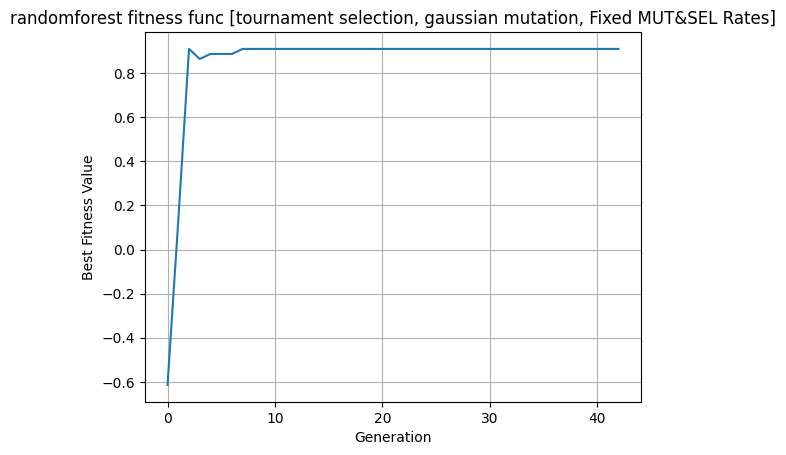

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Setting        :  ['randomforest', 'rank', 'gaussian', 0.7, 0.1, False]
Best Features  :  [' Per Share Net profit before tax (Yuan ¥)', ' Accounts Receivable Turnover', ' Current Liability to Assets', ' Quick Asset Turnover Rate', ' Equity to Long-term Liability', ' Interest Coverage Ratio (Interest expense to EBIT)', ' Equity to Liability']
Best Fitness   :  0.9545454545454546


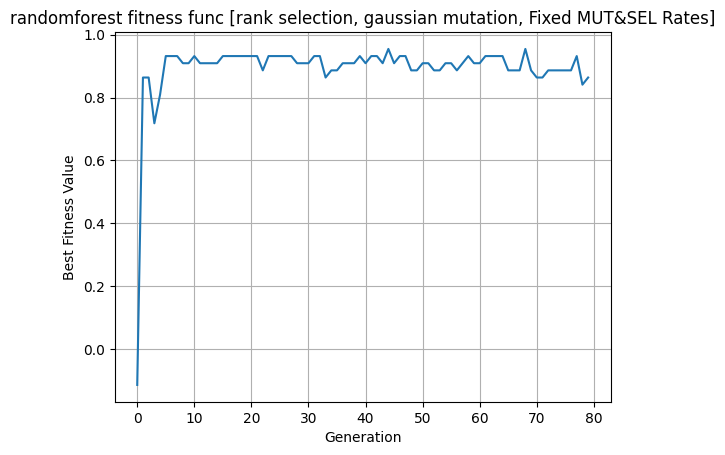

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['randomforest', 'roulette', 'gaussian', 0.7, 0.1, False]
Best Features  :  [' ROA(C) before interest and depreciation before interest', ' Per Share Net profit before tax (Yuan ¥)', ' Interest Coverage Ratio (Interest expense to EBIT)']
Best Fitness   :  0.9772727272727273


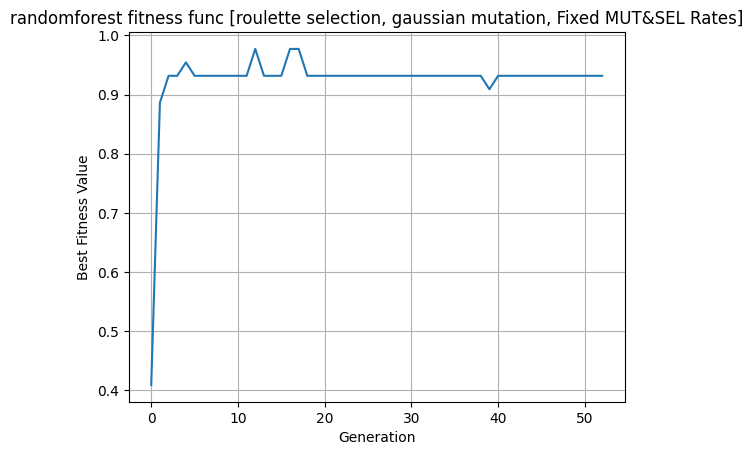

In [ ]:
settingsRanFor1 = [
    # Dataset,features,target,population_size,number of generation, fitness type, number of desired features, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'tournament','bitflip',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'rank','bitflip',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'roulette','bitflip',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'tournament','gaussian',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'rank','gaussian',0.7,0.1,False],
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'roulette','gaussian',0.7,0.1,False],
]

for setting in settingsRanFor1:
    fitness_type = setting[5]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_feature_selection_ga(setting,title,data,features,target,population_size,num_generations,fitness_type,num_desired_features,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()

**Dynamic MUL&SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['randomforest', 'tournament', 'gaussian', 0.7, 0.1, True]
Best Features  :  [' Operating Profit Per Share (Yuan ¥)', ' Regular Net Profit Growth Rate', ' Net worth/Assets', ' Accounts Receivable Turnover', ' Inventory/Current Liability']
Best Fitness   :  0.9318181818181818


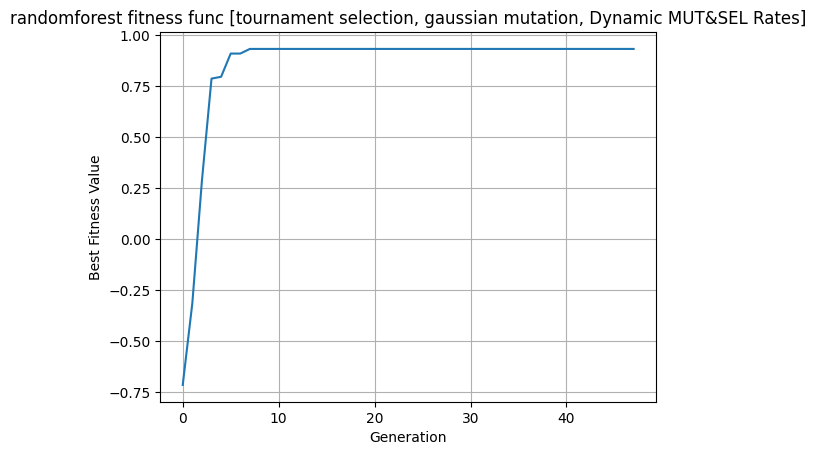

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['randomforest', 'rank', 'gaussian', 0.7, 0.1, True]
Best Features  :  [' ROA(C) before interest and depreciation before interest', ' Debt ratio %', ' Accounts Receivable Turnover', ' Operating Funds to Liability', ' Quick Asset Turnover Rate', ' Current Liability to Liability', ' Current Liability to Equity']
Best Fitness   :  0.9772727272727273


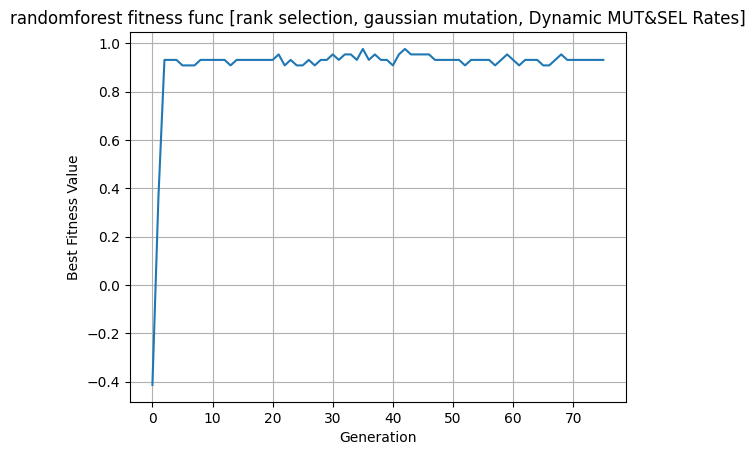

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Met Stopping Criteria - count_num_gen == 40

Setting        :  ['randomforest', 'roulette', 'gaussian', 0.7, 0.1, True]
Best Features  :  [' Operating Gross Margin', ' Operating Expense Rate', ' Net Value Per Share (A)', ' Regular Net Profit Growth Rate', ' Net Value Growth Rate', ' Debt ratio %', ' Total Asset Turnover']
Best Fitness   :  0.9090909090909091


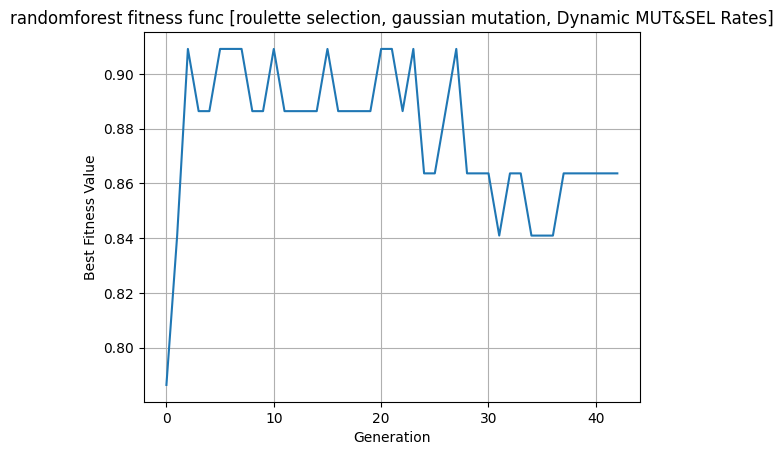

In [ ]:
settingsRanFor2 = [
    # Dataset,features,target,population_size,number of generation, fitness type, number of desired features, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'tournament','gaussian',0.7,0.1,True],
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'rank','gaussian',0.7,0.1,True],
    [data,features,target,population_size,num_generations,'randomforest',num_desired_features,'roulette','gaussian',0.7,0.1,True],
]

for setting in settingsRanFor2:
    fitness_type = setting[5]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_feature_selection_ga(setting,title,data,features,target,population_size,num_generations,fitness_type,num_desired_features,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()

In [ ]:
best_fitness_value_index_randomForest = np.argmax(all_best_fitness)

randomForest_best_features = all_best_features[best_fitness_value_index_randomForest]
randomForest_best_fitness = all_best_fitness[best_fitness_value_index_randomForest]

all_settings = settingsRanFor1 + settingsRanFor2
best_setting = [all_settings[best_fitness_value_index_randomForest][5],
      all_settings[best_fitness_value_index_randomForest][7],
      all_settings[best_fitness_value_index_randomForest][8],
      all_settings[best_fitness_value_index_randomForest][9],
      all_settings[best_fitness_value_index_randomForest][10],
      all_settings[best_fitness_value_index_randomForest][11]]

print("Random Forest Classifier")
print("Best Settings      - ", best_setting)
print("Best Fitness Value - ", randomForest_best_fitness)
print("Best Features      - ", randomForest_best_features)

Random Forest Classifier
Best Settings      -  ['randomforest', 'roulette', 'gaussian', 0.7, 0.1, False]
Best Fitness Value -  0.9772727272727273
Best Features      -  [' ROA(C) before interest and depreciation before interest', ' Debt ratio %', ' Accounts Receivable Turnover', ' Operating Funds to Liability', ' Quick Asset Turnover Rate', ' Current Liability to Liability', ' Current Liability to Equity']


# Fuzzy Logic Design - Fuzzy Rules Generation

In [ ]:
# best_features = randomForest_best_features
best_features = [' ROA(C) before interest and depreciation before interest',
 ' Debt ratio %',
 ' Accounts Receivable Turnover',
 ' Operating Funds to Liability',
 ' Quick Asset Turnover Rate',
 ' Current Liability to Liability',
 ' Current Liability to Equity']

In [ ]:
def get_features_membership(dataset,col):
    min_val = np.min(dataset[col])
    max_val = np.max(dataset[col])
    mid_val = np.median(dataset[col])

    universe = np.linspace(np.floor(min_val), np.ceil(max_val), 10000)

    feature = ctrl.Antecedent(universe, str(col))
    trimf_min = fuzz.trimf(feature.universe, [min_val, min_val, mid_val])
    trimf_mid = fuzz.trimf(feature.universe, [min_val, mid_val, max_val])
    trimf_max = fuzz.trimf(feature.universe, [mid_val, max_val, max_val])
    feature['min'] = trimf_min
    feature['mid'] = trimf_mid
    feature['max'] = trimf_max

    membership_df = pd.DataFrame(dataset[col])
    membership_df['min'] = fuzz.interp_membership(universe,trimf_min,dataset[col])
    membership_df['mid'] = fuzz.interp_membership(universe,trimf_mid,dataset[col])
    membership_df['max'] = fuzz.interp_membership(universe,trimf_max,dataset[col])
    membership_df['membership'] = membership_df[['min','mid','max']].idxmax(axis = 1)
    membership_df['degree'] = membership_df[['min','mid','max']].max(axis = 1)
    return feature,membership_df

In [ ]:
def get_target_membership(dataset):
    min_val = 0
    max_val = 1

    universe = np.arange(0,1.1,1)

    # Define output variable
    target = ctrl.Consequent(universe,'company_status_class')

    # Define membership functions for output variable
    trimf_min = fuzz.trimf(target.universe, [0, 0, 1])
    trimf_max = fuzz.trimf(target.universe, [0, 1, 1])

    target['no_bankrupt'] = trimf_min
    target['bankrupt'] = trimf_max

    membership_df = pd.DataFrame(dataset)
    membership_df['no_bankrupt'] = fuzz.interp_membership(universe,trimf_min,dataset)
    membership_df['bankrupt'] = fuzz.interp_membership(universe,trimf_max,dataset)
    membership_df['membership'] = membership_df[['no_bankrupt','bankrupt']].idxmax(axis = 1)
    membership_df['degree'] = membership_df[['no_bankrupt','bankrupt']].max(axis = 1)
    return target,membership_df


In [ ]:
feature_membership_df = []
feature_membership = []
for item in best_features:
  feature_mf,feature_mf_df = get_features_membership(X_train,item)
  feature_membership_df.append(feature_mf_df)
  feature_membership.append(feature_mf)

feature_membership_df[0].head()

,ROA(C) before interest and depreciation before interest,min,mid,max,membership,degree
2577,0.470531,0.008449,0.991551,0.000000,mid,0.991551
527,0.392385,0.182084,0.817916,0.000000,mid,0.817916
4375,0.473212,0.002491,0.997509,0.000000,mid,0.997509
3472,0.639107,0.000000,0.299772,0.700228,max,0.700228
1640,0.432116,0.093804,0.906196,0.000000,mid,0.906196


In [ ]:
target_membership,target_membership_df = get_target_membership(y_train)
target_membership_df.head()

,Bankrupt?,no_bankrupt,bankrupt,membership,degree
2577,1,0.0,1.0,bankrupt,1.0
527,1,0.0,1.0,bankrupt,1.0
4375,1,0.0,1.0,bankrupt,1.0
3472,0,1.0,0.0,no_bankrupt,1.0
1640,1,0.0,1.0,bankrupt,1.0


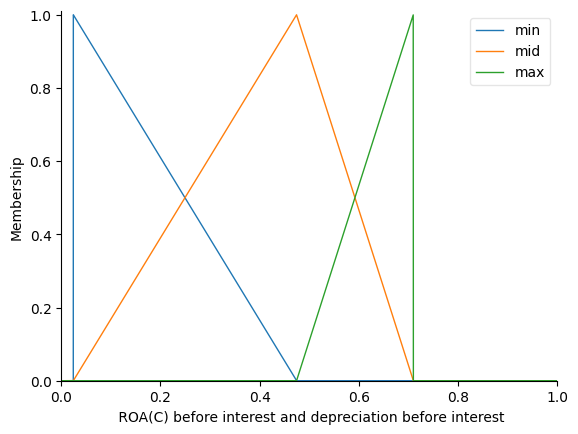

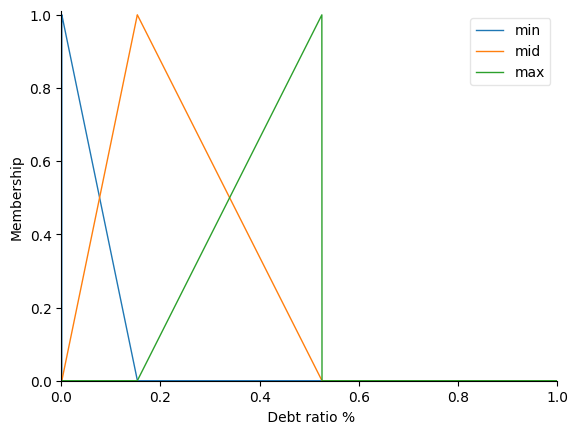

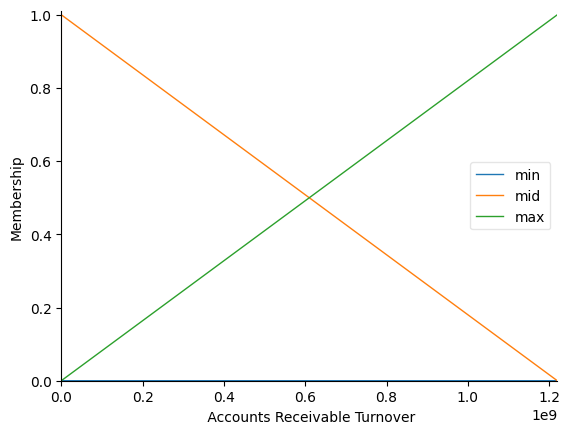

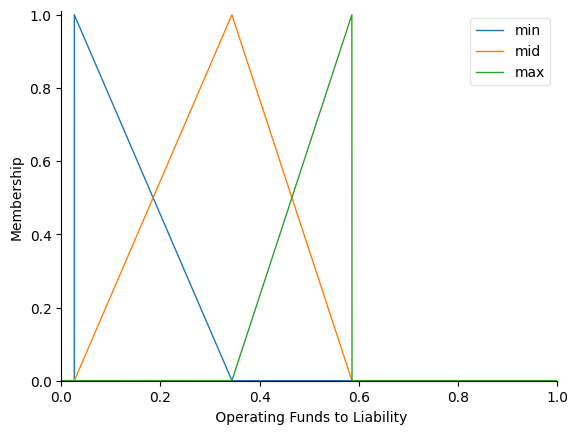

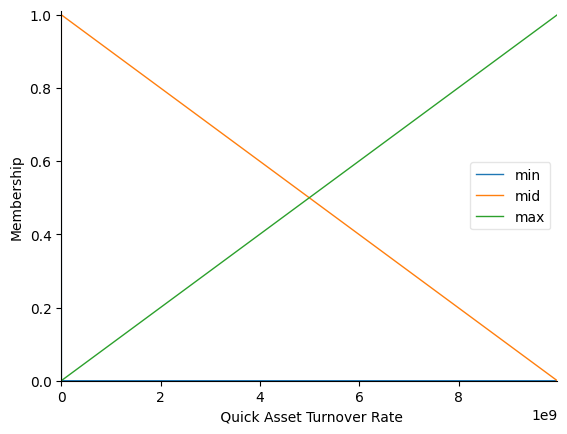

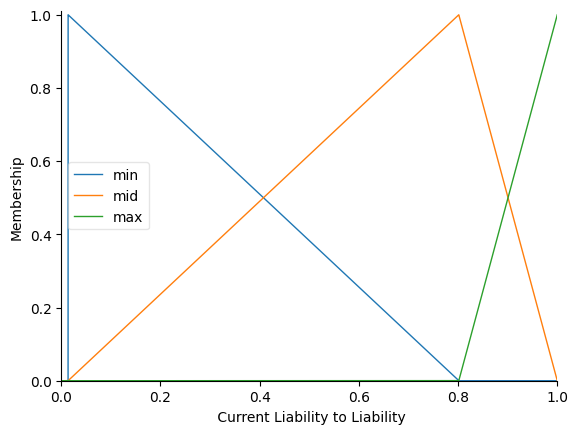

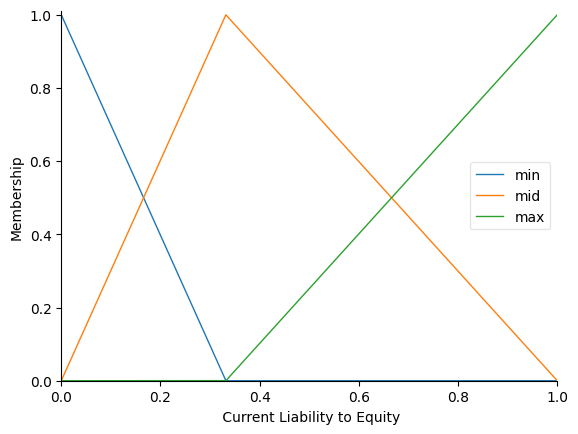

In [ ]:
for i in range(len(feature_membership)):
  feature_membership[i].view()

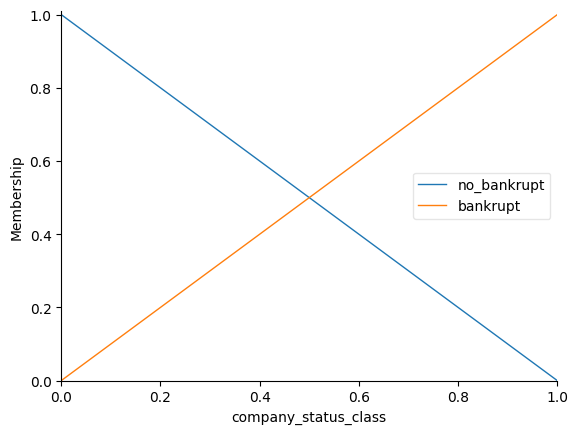

In [ ]:
target_membership.view()

In [ ]:
train_data = pd.concat([X_train[best_features],y_train],axis = 1)

In [ ]:
def get_rules(train_data,X_train,y_train):
  rule_df = train_data.copy()
  rule_df['degree'] = np.ones(X_train.shape[0])
  for i,col in enumerate(train_data.columns):
    if i != len(train_data.columns) - 1:
      membership = feature_membership_df[i]
    else:
      membership = target_membership_df
    rule_df[col] = membership['membership']
    rule_df['degree'] *= membership['degree']

  final_rule =  rule_df
  final_rule['Bankrupt'] = y_train.iloc[:]
  final_rule  = final_rule.groupby(list(rule_df.columns[:-3])).max()
  final_rule = final_rule.reset_index()
  col_to_move = final_rule.pop('degree')
  final_rule['degree'] = col_to_move
  return final_rule

In [ ]:
antecedent_rules = get_rules(train_data,X_train,y_train)
antecedent_rules.sort_values(by = 'degree',ascending=False,inplace = True)
antecedent_rules

,ROA(C) before interest and depreciation before interest,Debt ratio %,Accounts Receivable Turnover,Operating Funds to Liability,Quick Asset Turnover Rate,Current Liability to Liability,Current Liability to Equity,Bankrupt?,Bankrupt,degree
8,mid,mid,max,mid,min,mid,mid,bankrupt,1,6.257852e-01
16,mid,mid,mid,mid,min,max,mid,no_bankrupt,1,2.732665e-06
19,mid,mid,mid,mid,min,min,mid,no_bankrupt,1,3.221506e-07
12,mid,mid,mid,mid,mid,max,mid,no_bankrupt,1,1.369061e-07
6,max,min,mid,mid,min,max,mid,no_bankrupt,0,6.153724e-08
18,mid,mid,mid,mid,min,mid,mid,no_bankrupt,1,4.876986e-08
25,mid,min,mid,mid,mid,mid,mid,no_bankrupt,0,3.570818e-08
13,mid,mid,mid,mid,mid,mid,max,bankrupt,1,3.264266e-08
14,mid,mid,mid,mid,mid,mid,mid,no_bankrupt,1,2.828460e-08
9,mid,mid,mid,mid,max,max,mid,no_bankrupt,1,2.402886e-08


**Rules Generation Method 1**

The function extract_rules takes antecedent rules from a DataFrame, generates all possible combinations of these rules using logical operators [AND & OR], constructs fuzzy logic rules, and returns a list of these rules. This enables creating a comprehensive set of fuzzy rules that can be used for decision-making in a fuzzy logic control system.

<br>

*Due to the significant computation requirement, this method is not feasible for our use*

In [ ]:
def extract_rules_method1():
    rules = []
    for _, item in antecedent_rules.iterrows():
        row = item[:-2]
        tempt_rules = []

        # Create antecedent memberships
        for mf, ante_term in zip(feature_membership, row[:-1]):
            tempt_ante_membership = mf[ante_term]
            tempt_rules.append(tempt_ante_membership)

        # Generate all combinations of & and | operators
        operator_combinations = list(itertools.product(['&', '|'], repeat=len(tempt_rules)-1))

        for operators in operator_combinations:
            rule_expr = tempt_rules[0]
            for i, op in enumerate(operators):
                if op == '&':
                    rule_expr = rule_expr & tempt_rules[i+1]
                elif op == '|':
                    rule_expr = rule_expr | tempt_rules[i+1]

            rule = ctrl.Rule(rule_expr, target_membership[row[-1]])
            rules.append(rule)

    return rules
rules = extract_rules_method1()
print(rules)

[IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[max]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[mid]) AND  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[max]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[mid]) OR  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[max]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) O

In [ ]:
print("Number of rules method 1: ",len(rules))

Number of rules method 1:  2432


**Rules Generation Method 2**

In [ ]:
def extract_rules_method2():
    rules = []
    for _, item in antecedent_rules.iterrows():
        row = item[:-2]
        tempt_rules = []

        # Create antecedent memberships
        for mf, ante_term in zip(feature_membership, row[:-1]):
            tempt_ante_membership = mf[ante_term]
            tempt_rules.append(tempt_ante_membership)

        rule_expr = []
        rule_expr.append(reduce(lambda x,y : x&y,tempt_rules))
        rule_expr.append(reduce(lambda x,y : x|y,tempt_rules))

        for item in rule_expr:
          rule = ctrl.Rule(item, target_membership[row[-1]])
          rules.append(rule)

    return rules
rules = extract_rules_method2()
print(rules)

[IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[max]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[mid]) AND  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[max]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[min]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  C

In [ ]:
print("Number of rules generated in Method 2 : ",len(rules))

Number of rules generated in Method 2 :  76


# Rules Selection - GA Algorithms <br>
**Types of fitness function**

    1. Accuracy
    2. F1Score  

    ### Penalty
    -Deduction of 0.1 is applied for each rules that exceeds the specified range(10).

**Selection methods**

    1. Tournament Selection
    2. Rank Selection
    3. Roulette-wheel Selection

**Mutation methods**

    1. Bit Flip Mutation
    2. Gaussian Mutation

**Stopping Criteria**

    1. When fitness value > 0.9
    2. When best fitness value does not improve for 30 consecutive generations

**Changes of mutation and crossover rate every generation loop [TRUE / FALSE]**

    1. crossover_rate *= 1.05
    2. mutation_rate *= 0.99

In [68]:
# Define a random state seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

def rules_selection_genetic_algo(data,target,rules,best_features,population_size,num_generations,fitness_type,selection_type = 'tournament',mutation_type = 'bitflip',crossover_rate = 0.7,mutation_rate = 0.01,changes_of_rates = True):
  best_fitness_in_generation = -sys.float_info.max
  best_ind_in_generation = None
  best_rules_in_generation = None
  collection_of_fitnesses = []
  count_num_gen = 0

  # Create the Fitness and Individual classes
  creator.create("FitnessMax",base.Fitness,weights = (1.0,))
  creator.create("Individual",list,fitness = creator.FitnessMax)

  # Initialize the toolbox
  toolbox = base.Toolbox()

  # Attribute generator: Define a function to randomly generate a feature selector (0 or 1)
  toolbox.register('attr_bool',random.randint,0,1)

  # Structure initializers: Define a function to create individuals and the population
  # toolbox.register('individual',init_individual,creator.Individual,size = len(features),num_features = 10)
  toolbox.register('individual',tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(rules))
  toolbox.register('population',tools.initRepeat,list,toolbox.individual)

  # Register the evaluation function
  if fitness_type == "accuracy":
    toolbox.register("evaluate",accuracy_fitness_function_for_prediction,rules_list = rules,list_of_features = best_features)
  elif fitness_type == "f1score":
    toolbox.register("evaluate",f1score_fitness_function_for_prediction,rules_list = rules,list_of_features = best_features)


  toolbox.register('mate',tools.cxTwoPoint)

  # Mutation
  if mutation_type == 'bitflip':
    toolbox.register('mutate',tools.mutFlipBit,indpb = 0.05)
  elif mutation_type == 'gaussian':
    toolbox.register('mutate',tools.mutGaussian,mu = 0,sigma = 1,indpb = 0.5)

  # Selection
  if selection_type == 'tournament':
    toolbox.register('select',tools.selTournament,tournsize  = 3)
  elif selection_type == 'roulette':
    toolbox.register('select',tools.selRoulette)
  elif selection_type == 'rank':
    toolbox.register('select',tools.selBest)

  # Initialize population
  population = toolbox.population(n = population_size)

  fitnesses = list(map(toolbox.evaluate,population))

  for ind,fit in zip(population,fitnesses):
    ind.fitness.values = fit

  # Variable keeping track of the number of generations
  gen = 0

  while gen < num_generations:
    gen+=1

    # Select the next generation individuals
    offspring = toolbox.select(population,len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone,offspring))

    # Apply crossover and mutation on the offspring
    for child1,child2 in zip(offspring[::2],offspring[1::2]):
      if random.random() < 0.5:
        toolbox.mate(child1,child2)
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
      if random.random() < 0.2:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

    fitnesses = map(toolbox.evaluate,invalid_ind)

    for ind,fit in zip(invalid_ind,fitnesses):
      ind.fitness.values = fit

    # Replace the population with the offspring
    population[:] = offspring

    # Stopping criteria
    try:
      best_ind_in_population = tools.selBest(population,1)[0]
      best_fitness_in_population = best_ind_in_population.fitness.values[0]
    except IndexError:
      break
    selected_rules = [rul for rul,bit in zip(rules,best_ind_in_population) if bit == 1]

    # print("Generation        : ",gen)
    # print("Best Fitness      : ",best_fitness_in_population)
    # print()

    if best_fitness_in_population > best_fitness_in_generation:
      best_fitness_in_generation = best_fitness_in_population
      best_ind_in_generation = best_ind_in_population
      best_rules_in_generation = selected_rules
      count_num_gen = 0
    else:
      count_num_gen += 1

    if changes_of_rates:
      #  Modify crossover rate and mutation -rate every generation loop
      crossover_rate *= 1.05
      mutation_rate *= 0.99

    collection_of_fitnesses.append(best_fitness_in_population)

    if best_fitness_in_population >= 0.9:
      break

    if count_num_gen == 30:
      break

  return collection_of_fitnesses,best_rules_in_generation,best_fitness_in_generation

In [ ]:
# Plot the convergence
def plot_fitness_history(fitnesses,title):
  plt.plot(fitnesses)
  plt.xlabel("Generation")
  plt.ylabel("Best Fitness Value")
  plt.title(title)
  plt.grid()
  plt.show()

In [ ]:
# Fitness Function
import logging
# Set up logging
logging.basicConfig(level=logging.INFO)

def penalty_fitness_score(rules,score):
  if len(rules) > 10:
    score -= (len(rules) - 10) / 10

  return score

def accuracy_fitness_function_for_prediction(individual, rules_list, list_of_features):
    selected_rules = [rul for rul, bit in zip(rules_list, individual) if bit == 1]
    consequent_ctrl = ctrl.ControlSystem(selected_rules)
    pred = ctrl.ControlSystemSimulation(consequent_ctrl)

    predictions = []
    for i in range(len(X_test)):
        try:
            for feature_name, feature_value in zip(list_of_features, X_test.iloc[i]):
                pred.input[feature_name] = feature_value
            pred.compute()
            predict = 0 if pred.output['company_status_class'] < 0.5 else 1
            predictions.append(predict)
        except ValueError:
            predictions.append(-1)

    correct_predictions = sum(1 for pred, true_label in zip(predictions, y_test) if pred == true_label)
    acc = correct_predictions / len(y_test - predictions.count(-1))
    acc = penalty_fitness_score(selected_rules,acc)
    return acc,


def f1score_fitness_function_for_prediction(individual, rules_list, list_of_features):
    selected_rules = [rul for rul, bit in zip(rules_list, individual) if bit == 1]
    consequent_ctrl = ctrl.ControlSystem(selected_rules)
    pred = ctrl.ControlSystemSimulation(consequent_ctrl)

    predictions = []
    for i in range(len(X_test)):
      try:
        for feature_name, feature_value in zip(list_of_features, X_test.iloc[i]):
            pred.input[feature_name] = feature_value
        pred.compute()
        prediction = pred.output['company_status_class']
        predict = 0 if  prediction < 0.5 else 1
        predictions.append(predict)
      except ValueError:
        predictions.append(-1)

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for pred, true_label in zip(predictions, y_test):
        if pred == -1:
          continue
        if pred == 1 and true_label == 1:
            TP += 1
        elif pred == 0 and true_label == 0:
            TN += 1
        elif pred == 1 and true_label == 0:
            FP += 1
        elif pred == 0 and true_label == 1:
            FN += 1

    if TP + FP == 0 or TP + FN == 0:
        return 0.0,

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    if precision + recall == 0:
        return 0.0,

    f1score = (2 * precision * recall) / (precision + recall)
    f1score = penalty_fitness_score(selected_rules,f1score)
    return f1score,

In [ ]:
def run_rules_selection_ga(setting,title,data,target,rules,best_features,population_size,num_generations,fitness_type,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates):

  fitnesses, best_rules, best_fitness = rules_selection_genetic_algo(X_train,
                                                                        y_train,
                                                                        rules,
                                                                        best_features,
                                                                        population_size,
                                                                        num_generations,
                                                                        fitness_type,
                                                                        selection_type,
                                                                        mutation_type,
                                                                        crossover_rate,
                                                                        mutation_rate,
                                                                        changes_of_rates)

  print("Setting        : ", setting)
  print("Best Rules     : ", best_rules)
  print("Best Fitness   : ", best_fitness)
  plot_fitness_history(fitnesses,title)


In [75]:
# Parameters
data = X_train
target = y_train
population_size = 10
num_generations = 50

###**Accuracy Fitness Function**

**Fixed SEL&MUT Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'tournament', 'bitflip', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[mid]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[max]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[min]) AND  Accounts Receivable T

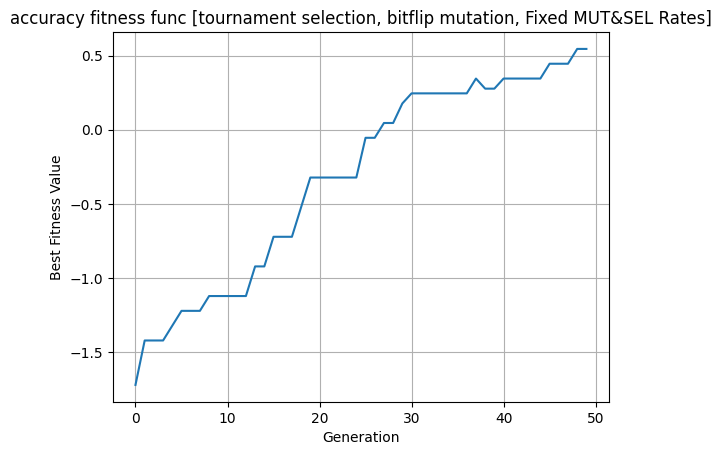

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'rank', 'bitflip', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[max]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[min]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[m

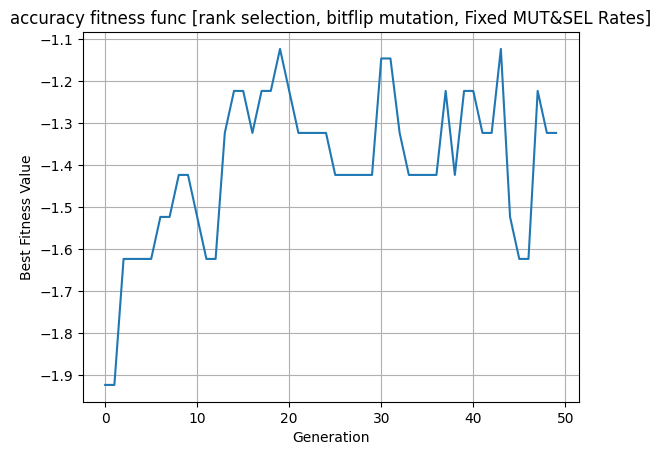

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'roulette', 'bitflip', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[max]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[min]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnov

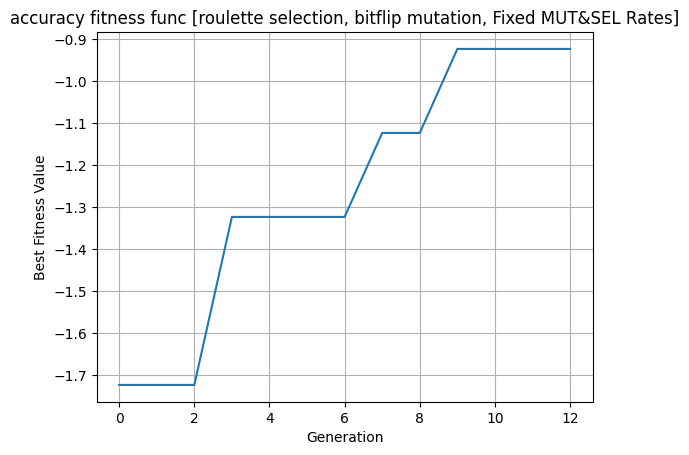

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'tournament', 'gaussian', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[mid]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[min]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[min] OR  Debt ratio %[mid]) OR  Accounts Receiva

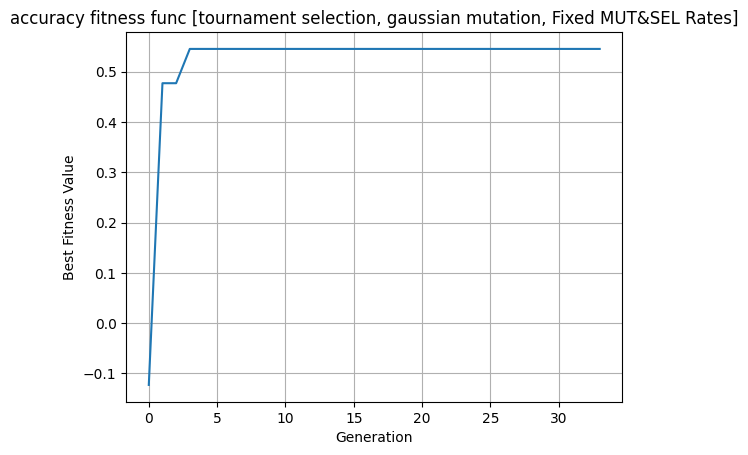

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'rank', 'gaussian', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[min]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[max] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[min]) AND  Accounts Receivable Turnover[

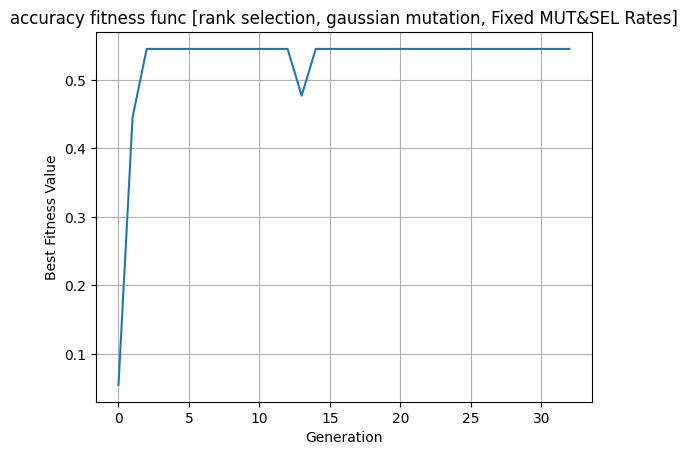

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'roulette', 'gaussian', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[max]) OR  Current Liability to Liability[min]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[min] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[mid]) AND  Current Liability to Liability[mid]) AND  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[min]) OR  Accounts Receivable Turnove

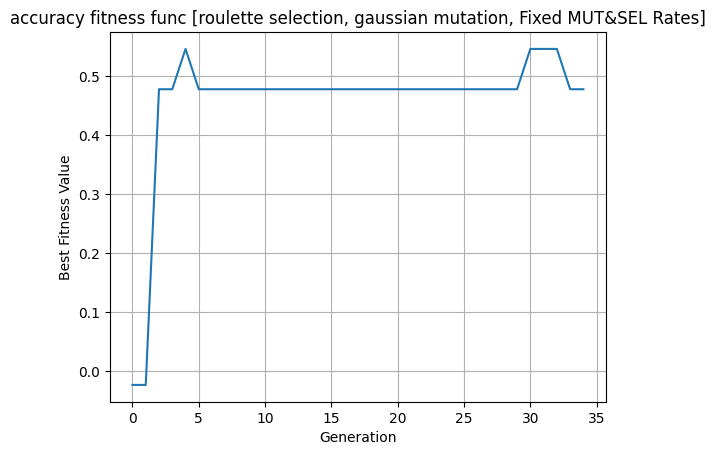

In [76]:
settingsAccuracy1 = [
    # X_train,y_train,rules,best features,population size,number of generation, fitness type, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,target,rules,best_features,population_size,num_generations,'accuracy','tournament','bitflip',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','rank','bitflip',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','roulette','bitflip',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','tournament','gaussian',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','rank','gaussian',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','roulette','gaussian',0.7,0.1,False]
]

for setting in settingsAccuracy1:
    fitness_type = setting[6]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_rules_selection_ga(setting,title,data,target,rules,best_features,population_size,num_generations,fitness_type,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()

**Dynamic SEL&MUT Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'tournament', 'bitflip', 0.7, 0.1, True]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[min]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[mid]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[max] OR  Debt ratio %[min]) OR  Accounts Receivable Turn

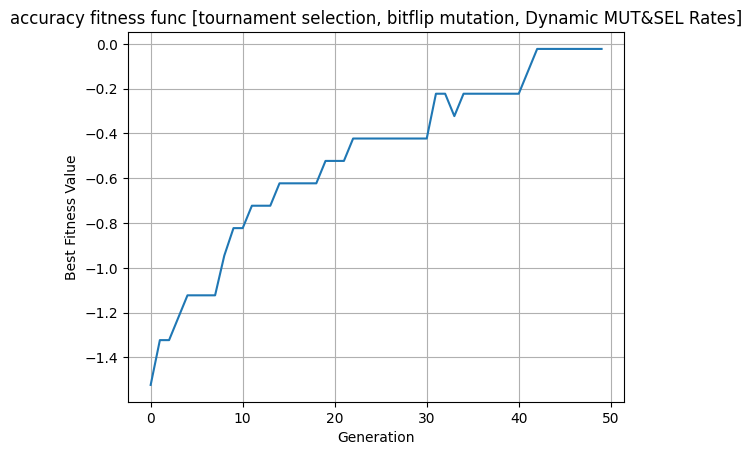

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'tournament', 'gaussian', 0.7, 0.1, True]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[min] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[max]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[max] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax]
Best Fitness   :  0.5454545454545454


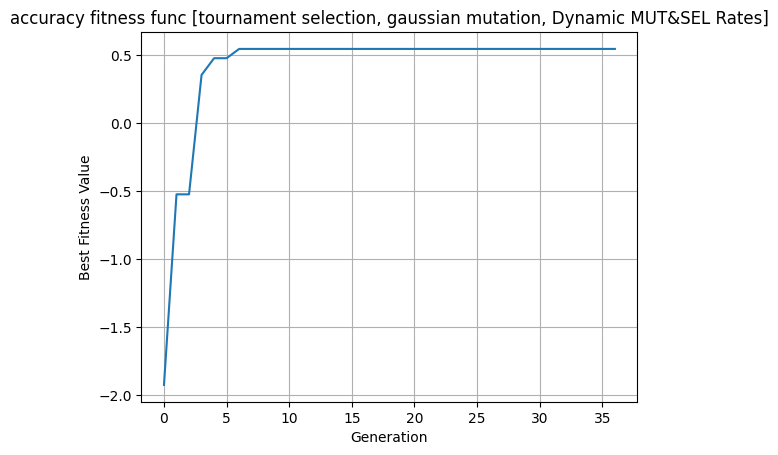

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'rank', 'gaussian', 0.7, 0.1, True]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[max]) OR  Current Liability to Liability[min]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[max] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[max]) AND  Current Liability to Liability[mid]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[

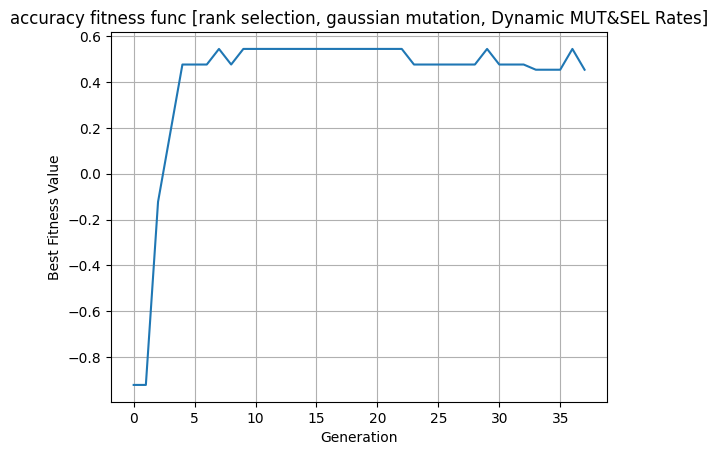

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['accuracy', 'roulette', 'gaussian', 0.7, 0.1, True]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[min]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[min] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[

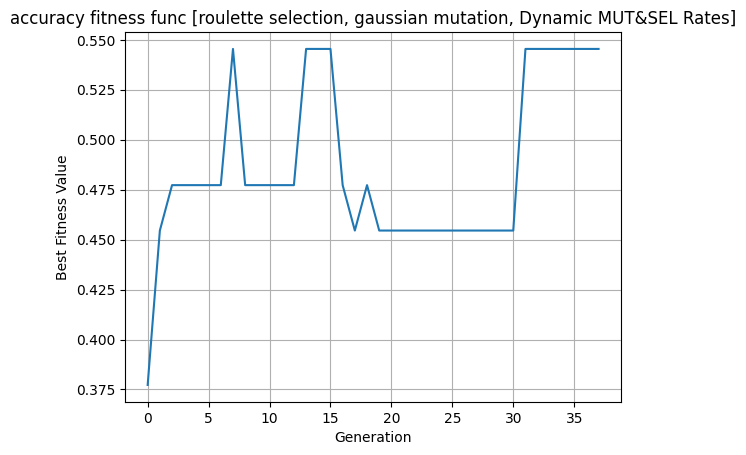

In [78]:
settingsAccuracy2 = [
    # X_train,y_train,rules,best features,population size,number of generation, fitness type, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,target,rules,best_features,population_size,num_generations,'accuracy','tournament','bitflip',0.7,0.1,True],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','tournament','gaussian',0.7,0.1,True],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','rank','gaussian',0.7,0.1,True],
    [data,target,rules,best_features,population_size,num_generations,'accuracy','roulette','gaussian',0.7,0.1,True]
]

for setting in settingsAccuracy2:
    fitness_type = setting[6]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_rules_selection_ga(setting,title,data,target,rules,best_features,population_size,num_generations,fitness_type,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()

###**F1Score Fitness Function**

**Fixed SEL&MUT Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['f1score', 'tournament', 'bitflip', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[min]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[max] OR  Debt ratio %[min]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[min]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[min]) AND  Accounts Receivable Turnover

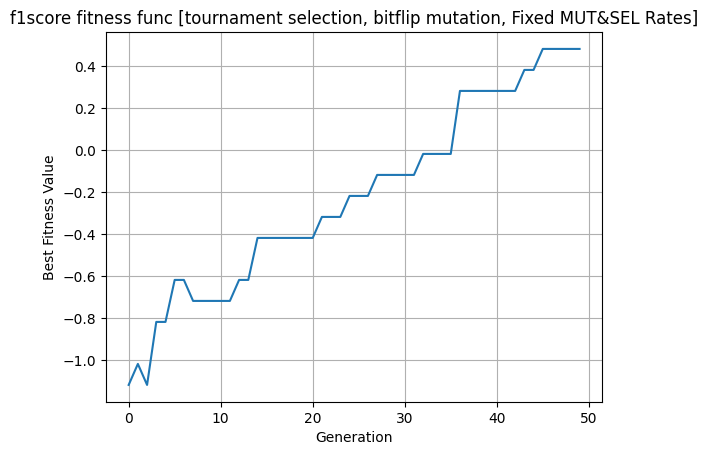


Setting        :  ['f1score', 'rank', 'bitflip', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[min]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnove

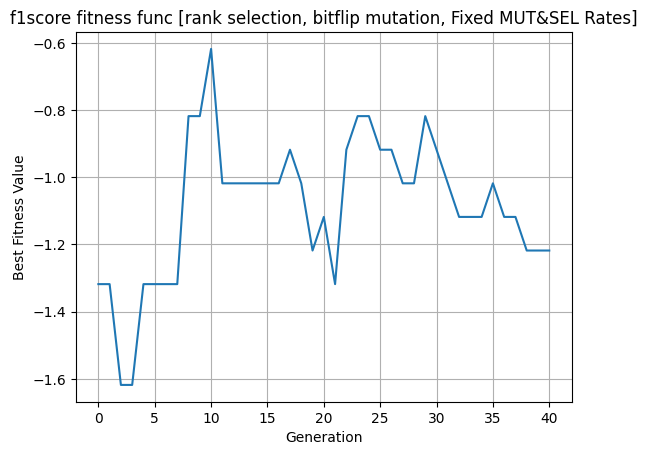


Setting        :  ['f1score', 'roulette', 'bitflip', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[max]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[mid]) AND  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[min]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[min]) OR  Accounts Receivable Turnover

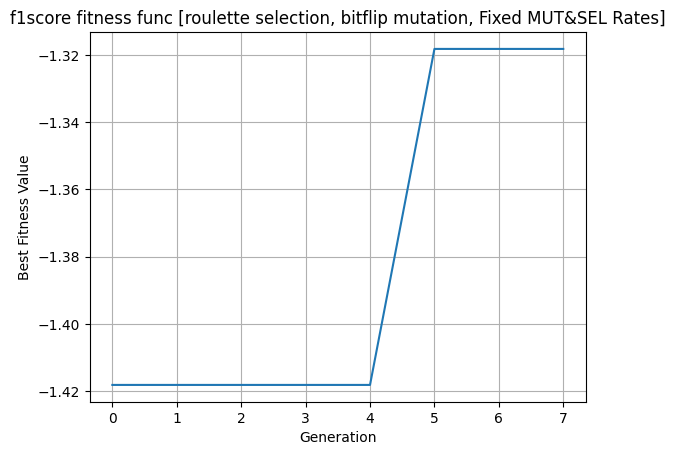


Setting        :  ['f1score', 'tournament', 'gaussian', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[min] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[max]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[max] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax]
Best Fitness   :  1.0


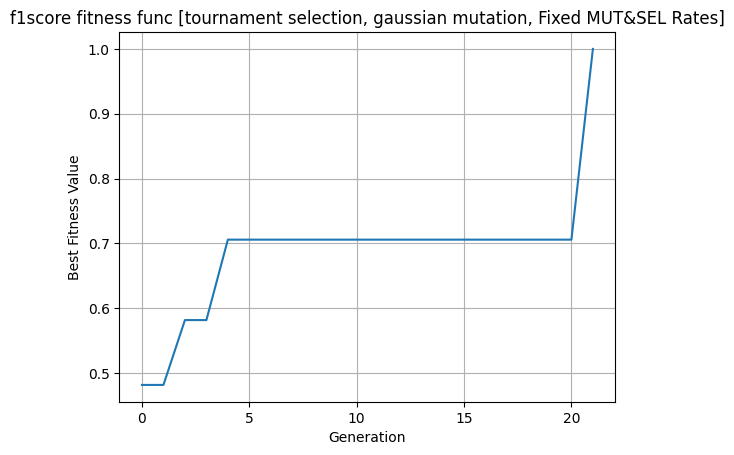


Setting        :  ['f1score', 'rank', 'gaussian', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[min] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[mid]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[mid] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax]
Best Fitness   :  1.0


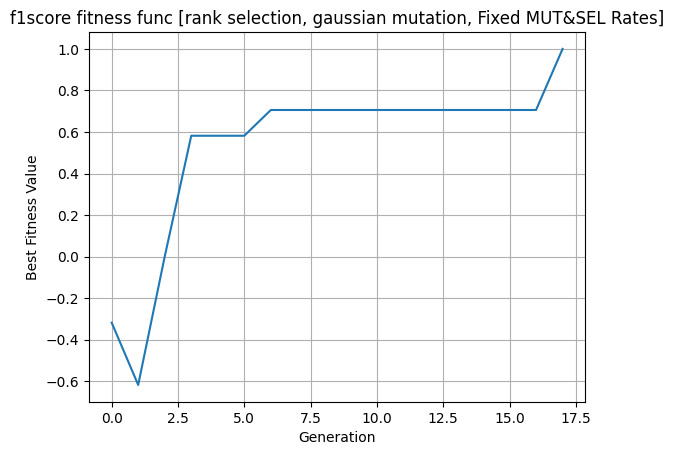


Setting        :  ['f1score', 'roulette', 'gaussian', 0.7, 0.1, False]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[min] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[max]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[max] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax]
Best Fitness   :  1.0


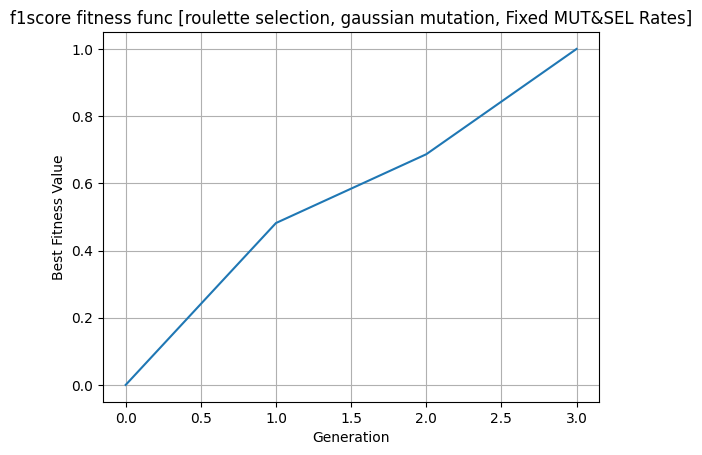

In [77]:
settingsF1score = [
    # X_train,y_train,rules,best features,population size,number of generation, fitness type, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,target,rules,best_features,population_size,num_generations,'f1score','tournament','bitflip',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'f1score','rank','bitflip',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'f1score','roulette','bitflip',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'f1score','tournament','gaussian',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'f1score','rank','gaussian',0.7,0.1,False],
    [data,target,rules,best_features,population_size,num_generations,'f1score','roulette','gaussian',0.7,0.1,False]
]

for setting in settingsF1score:
    fitness_type = setting[6]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_rules_selection_ga(setting,title,data,target,rules,best_features,population_size,num_generations,fitness_type,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()

**Dynamic SEL&MUT Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Setting        :  ['f1score', 'tournament', 'gaussian', 0.7, 0.1, True]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[max]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[max] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[min]) OR  Accounts Receivable Turnover[mid]

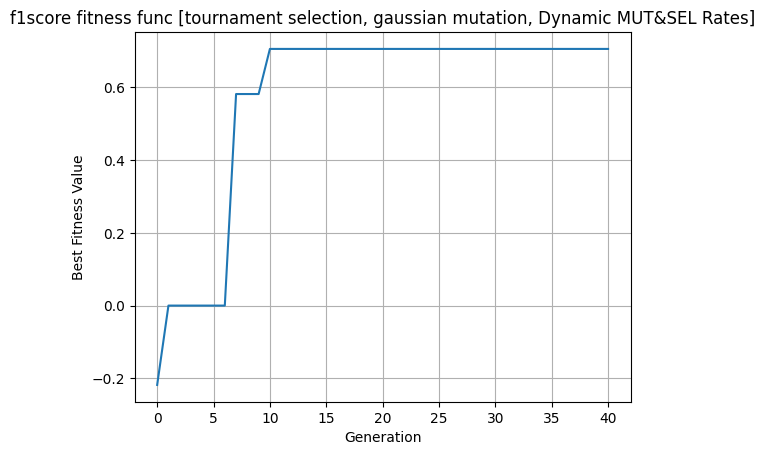


Setting        :  ['f1score', 'rank', 'gaussian', 0.7, 0.1, True]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[max] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[mid]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[mid]) AND  Accounts Receivable Turnover[mid]) A

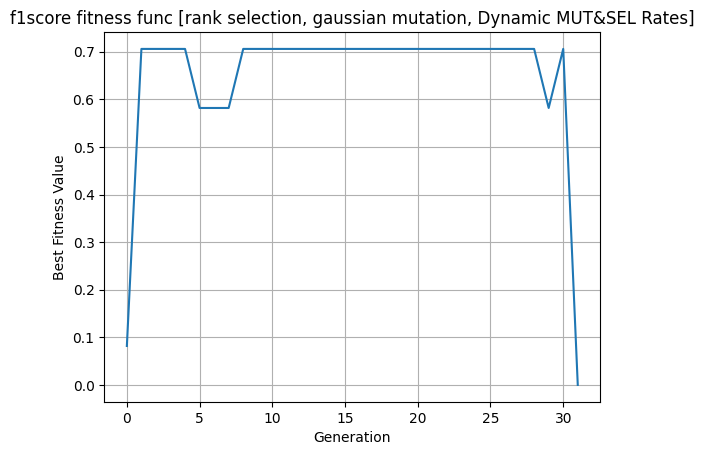


Setting        :  ['f1score', 'roulette', 'gaussian', 0.7, 0.1, True]
Best Rules     :  [IF ((((( ROA(C) before interest and depreciation before interest[mid] AND  Debt ratio %[min]) AND  Accounts Receivable Turnover[mid]) AND  Operating Funds to Liability[mid]) AND  Quick Asset Turnover Rate[min]) AND  Current Liability to Liability[max]) AND  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[mid] OR  Debt ratio %[mid]) OR  Accounts Receivable Turnover[mid]) OR  Operating Funds to Liability[mid]) OR  Quick Asset Turnover Rate[mid]) OR  Current Liability to Liability[min]) OR  Current Liability to Equity[mid] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax, IF ((((( ROA(C) before interest and depreciation before interest[min] AND  Debt ratio %[mid]) AND  Accounts Receivable Tur

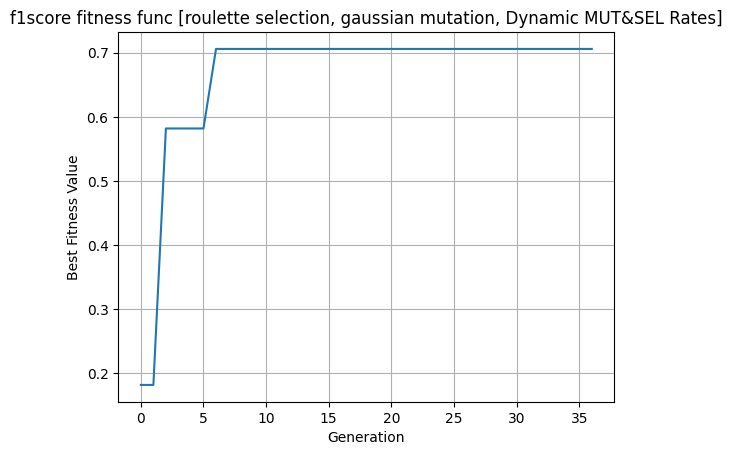

In [93]:
settingsF1score2 = [
    # X_train,y_train,rules,best features,population size,number of generation, fitness type, selection type, mutation type,
    # crossover rate, mutation rate, changes of rates:bool
    [data,target,rules,best_features,population_size,num_generations,'f1score','tournament','gaussian',0.7,0.1,True],
    [data,target,rules,best_features,population_size,num_generations,'f1score','rank','gaussian',0.7,0.1,True],
    [data,target,rules,best_features,population_size,num_generations,'f1score','roulette','gaussian',0.7,0.1,True]
]

for setting in settingsF1score2:
    fitness_type = setting[6]
    selection_type = setting[7]
    mutation_type = setting[8]
    crossover_rate = setting[9]
    mutation_rate = setting[10]
    changes_of_rates = setting[11]

    if changes_of_rates:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Dynamic MUT&SEL Rates]"
    else:
      title = f"{fitness_type} fitness func [{selection_type} selection, {mutation_type} mutation, Fixed MUT&SEL Rates]"

    setting = [fitness_type,selection_type,mutation_type,crossover_rate,mutation_rate,changes_of_rates]
    run_rules_selection_ga(setting,title,data,target,rules,best_features,population_size,num_generations,fitness_type,selection_type,mutation_type,
                            crossover_rate,mutation_rate,changes_of_rates)
    print()